## Debye Model Fitting to Specific Heat Data

The Debye model is a method for estimating the phonon contribution to the specific heat of a solid material [[wikipedia](https://en.wikipedia.org/wiki/Debye_model)]. Here, a code is introduced for fitting experimental data of speicific heat $C_v(T)$, as a function of temperature, to a explicit function of the Debye model:
$$
  C_v(T) = 9Nk_B (\frac{T}{T_D})\int_0^{T_D/T} \frac{x^4 e^x}{(e^x-1)^2}dx, 
$$
where $N$ is the number of atoms in the solid, $k_B$ is the Boltzman constant, and $T_D$ is the Debye temperature.



For example, we're using the data of an antiferromagnetic Mott insulator Sr<sub>2</sub>CrO<sub>4</sub> [[Sakurai, 2014](https://doi.org/10.7566/JPSJ.83.123701)], which shows clear multiple phase transitions of spin and orbital orderings with temperature varying [[Min-Cheol Lee, 2021](https://arxiv.org/abs/2110.14004)].

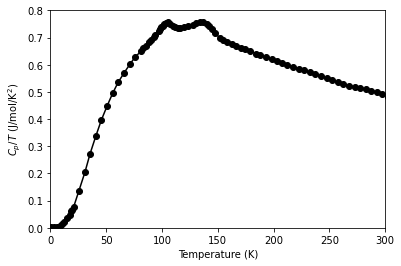

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

fname = 'Sr2CrO4.csv'
df = pd.read_csv(fname)
df.dropna(inplace=True)

Cp = df["Cp/T"]*df["Temperature"]
df.insert(2,"Cp", Cp, True)

p1 = df.plot(x="Temperature",y="Cp/T",marker='o',color='k',
    xlabel='Temperature (K)',ylabel='$C_p/T$ (J/mol/K$^2$)', 
    xlim=[0,300],ylim=[0,0.8],legend=False)

From the specific data ($C_p/T$) of Sr<sub>2</sub>CrO<sub>4</sub>, the multiple phase transitions are obvious, especially around Neel temperature at $T_N$ = 112 K due to antiferromagnetic spin ordering below $T_N$, and the orbital ordering temperature at $T_O$ = 140 K. Therefore, for fitting the specific heat to purely phonon contribution using the Debye model, we need to use the data away from the phase transition temperatures. Here, we choose to use the data at $T$ < 20 K and $T$ > 180 K, given $T_N$ and $T_O$, as well as $T_S$ = 50 K, which is another phase transition temperature of the stripe-type spin-orbital ordering. 

In [8]:
T_lower = 20
T_upper = 180

df_lower = df[df.iloc[:,0] < T_lower]
df_upper = df[df.iloc[:,0] > T_upper]
df_fit = pd.concat([df_lower, df_upper])

We now fit the selective data to a function of the Debye model.

C:\Users\minch\AppData\Local\Temp/ipykernel_27712/916630447.py:9: RuntimeWarning: overflow encountered in double_scalars
  Cp = 9*N*kB*(1/xD)**3 * integrate.quad(lambda x: x**4*np.exp(x) / (np.exp(x)-1)**2, 0, xD)[0]


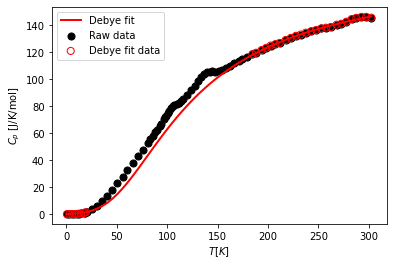

In [10]:
import numpy as np
from scipy import integrate as integrate
from scipy.optimize import curve_fit

kB = 1.38064852
@np.vectorize
def Debye(T,N,TD,g):
    xD = TD/T
    Cp = 9*N*kB*(1/xD)**3 * integrate.quad(lambda x: x**4*np.exp(x) / (np.exp(x)-1)**2, 0, xD)[0]
    Ce = g*T
    return Cp+Ce


T_all = df['Temperature']
Cp_all = df['Cp']

T = df_fit['Temperature']
Cp = df_fit['Cp']

popt, pcov = curve_fit(Debye, T,Cp, [40,450,2], maxfev=2000)

TD = popt[1]
#delta_TD = np.sqrt(pcov[1, 0])
#print(f"T_D = {TD:.5} K")

plt.scatter(T_all,Cp_all, s=50, facecolors='k', edgecolors='k', label = 'Raw data')
plt.scatter(T,Cp, s=50, facecolors='none', edgecolors='r', label = 'Debye fit data')
plt.xlabel('$T [K]$')
plt.ylabel('$C_p$ [J/K/mol]')
plt.plot(T_all, Debye(T_all, *popt), color='r',linewidth = 2,label = 'Debye fit')
plt.legend()

Here, we extract the magnetic contribution to the specific heat by subtrating the Debye fit results from the raw data. It's clear to see temperature-dependent anomalies at all three phase transition temperatures at $T_S$ = 50 K, $T_N$ = 112 K, and $T_O$ = 140 K.

C:\Users\minch\AppData\Local\Temp/ipykernel_27712/916630447.py:9: RuntimeWarning: overflow encountered in double_scalars
  Cp = 9*N*kB*(1/xD)**3 * integrate.quad(lambda x: x**4*np.exp(x) / (np.exp(x)-1)**2, 0, xD)[0]


(-2.0, 15.0)

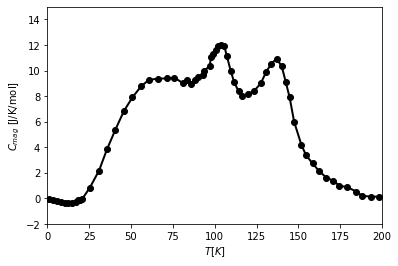

In [12]:
C_mag = Cp_all - Debye(T_all, *popt)
plt.plot(T_all, C_mag,marker='o',color='k',linewidth = 2,label = 'Debye fit')
plt.xlabel('$T [K]$')
plt.ylabel('$C_{mag}$ [J/K/mol]')
plt.xlim([0,200])
plt.ylim([-2,15])